In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
import json
import torch
import cv2
import zlib
import base64
from utils import *
import tqdm
try:
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "Apple Roboto"
except:
    pass

%load_ext autoreload
%autoreload 3

# Download the FSOCO segmentation dataset


In [ ]:
!if ! [ -e "fsoco_segmentation.zip" ]; then curl -o fsoco_segmentation.zip http://fsoco.cs.uni-freiburg.de/datasets/fsoco_segmentation_train.zip ; fi
!if ! [ -d "fsoco_segmentation" ]; then unzip fsoco_segmentation.zip -d fsoco_segmentation; fi
!if [ "$(uname -s)" = 'Darwin' -a -d "__MACOSX" ]; then rm -r __MACOSX; fi
!rm fsoco_segmentation.zip

# Process data and convert the format


In [19]:
#  Meta
dataset_name = 'fsoco_segmentation'
dataset_dir = Path(dataset_name)
meta = dataset_dir / 'meta.json'
with open(meta) as f:
    meta = json.load(f)
print(meta)

{'classes': [{'title': 'seg_orange_cone', 'shape': 'bitmap', 'color': '#FF8000', 'geometry_config': {}, 'id': 2926554, 'hotkey': ''}, {'title': 'seg_yellow_cone', 'shape': 'bitmap', 'color': '#FFFF00', 'geometry_config': {}, 'id': 2926555, 'hotkey': ''}, {'title': 'blue_cone', 'shape': 'rectangle', 'color': '#2A00FF', 'geometry_config': {}, 'id': 2926556, 'hotkey': ''}, {'title': 'yellow_cone', 'shape': 'rectangle', 'color': '#FFFF00', 'geometry_config': {}, 'id': 2926557, 'hotkey': ''}, {'title': 'orange_cone', 'shape': 'rectangle', 'color': '#FF8000', 'geometry_config': {}, 'id': 2926558, 'hotkey': ''}, {'title': 'large_orange_cone', 'shape': 'rectangle', 'color': '#FF002A', 'geometry_config': {}, 'id': 2926559, 'hotkey': ''}, {'title': 'unknown_cone', 'shape': 'rectangle', 'color': '#3BDB0F', 'geometry_config': {}, 'id': 2926560, 'hotkey': ''}, {'title': 'seg_large_orange_cone', 'shape': 'bitmap', 'color': '#FF002A', 'geometry_config': {}, 'id': 2926561, 'hotkey': ''}, {'title': 'se

In [20]:
# Classes
classname_to_classid = {'background': 0}
i = 1
for classentry in meta['classes']:
    if "seg" in classentry['title']:
        classname_to_classid[classentry['title']] = i
        i += 1
print(classname_to_classid)

{'background': 0, 'seg_orange_cone': 1, 'seg_yellow_cone': 2, 'seg_large_orange_cone': 3, 'seg_blue_cone': 4, 'seg_unknown_cone': 5}


In [4]:
# Class IDs to colors
classid_to_color = {
    0: (20, 20, 20),
    1: (252, 132, 3),
    2: (231, 252, 3),
    3: (255, 0, 0),
    4: (3, 40, 252),
    5: (0, 255, 0),
}

In [5]:
#  Subdirectories with some batch of images and annotations
subdirs = filter(lambda x: x.is_dir(), dataset_dir.iterdir())

In [6]:
#  Get all image and annotation paths matched
img_ann_pairs = []
for subdir in subdirs:
    imdir = subdir / "img"
    anndir = subdir / "ann"
    ims = list(imdir.glob("*.png")) + list(imdir.glob("*.jpg"))
    anns = list(anndir.glob("*.json"))
    ims.sort()
    anns.sort()
    assert len(ims) == len(anns)
    img_ann_pairs += list(zip(ims, anns))
print("Found {} image-annotation pairs".format(len(img_ann_pairs)))
print("Example pair: {}".format(img_ann_pairs[0]))

Found 1517 image-annotation pairs
Example pair: (PosixPath('fsoco_segmentation/epflrt/img/amz_00825.png'), PosixPath('fsoco_segmentation/epflrt/ann/amz_00825.png.json'))


In [21]:
# Process dataset and put in a separate folder
processed = dataset_name + "_processed_np_only"
processed_dir = Path(processed)
processed_dir.mkdir(exist_ok=True)
processed_im = processed_dir / "img"
processed_im.mkdir(exist_ok=True)
processed_ann = processed_dir / "ann"
processed_ann.mkdir(exist_ok=True)

BLACK_BAR = 140


def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask


def json_to_mark_array(data):
    mask_image = np.zeros(
        (data["size"]["height"], data["size"]["width"]), dtype=np.uint8)
    for obj in data["objects"]:
        if obj["classTitle"] in classname_to_classid:
            origin_x, origin_y = obj["bitmap"]["origin"]
            mask_array = base64_2_mask(obj["bitmap"]["data"])
            mask_image[origin_y:origin_y + mask_array.shape[0],
                       origin_x:origin_x + mask_array.shape[1]] = mask_array * classname_to_classid[obj["classTitle"]]
    return mask_image


def mask_arr_to_color_image(mask_arr):
    color_image = np.zeros(
        (mask_arr.shape[0], mask_arr.shape[1], 3), dtype=np.uint8)
    for classid in classid_to_color:
        color_image[mask_arr == classid] = classid_to_color[classid]
    return color_image


for im, ann in tqdm.tqdm(img_ann_pairs):
    imname = processed_im / (im.name.split(".")[0] + ".npz")
    maskname = processed_ann / (ann.name.split(".")[0] + ".npz")
    if not imname.exists():
        # Get the image and process it
        image_arr = cv2.imread(str(im))
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
        image_arr = image_arr[BLACK_BAR:-BLACK_BAR, BLACK_BAR:-BLACK_BAR, :]
        image_arr = image_arr.transpose(2, 0, 1)
        np.savez_compressed(
            imname, image_arr)
    if not maskname.exists():
        #  Get the mask and process it
        with open(ann) as f:
            ann_json = json.load(f)
        mask_arr = json_to_mark_array(ann_json)
        mask_arr = mask_arr[BLACK_BAR:-BLACK_BAR, BLACK_BAR:-BLACK_BAR]
        one_hot_mask = class_mask_to_one_hot(mask_arr)
        one_hot_mask = one_hot_mask.astype(np.bool_)
        # Save the image and the mask
        np.savez_compressed(
            maskname, one_hot_mask)

  0%|          | 0/1517 [00:00<?, ?it/s]

100%|██████████| 1517/1517 [21:03<00:00,  1.20it/s]


In [ ]:
#  Load the newly processed masks and images
processed_imgs = list(processed_im.glob("*.jpeg"))
processed_imgs.sort()
processed_masks = list(processed_ann.glob("*.npz"))
processed_masks.sort()
processed_pairs = list(zip(processed_imgs, processed_masks))
print("Found {} processed image-annotation pairs".format(len(processed_pairs)))

In [ ]:
#  Visualize some
for im, ann in processed_pairs[:5]:
    image_arr = cv2.imread(str(im))
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
    mask_arr = np.load(str(ann))["arr_0"]
    color_image = mask_arr_to_color_image(mask_arr)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7), dpi=200)
    ax[0].imshow(image_arr)
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(color_image)
    ax[1].set_title("Mask")
    ax[1].axis("off")
    plt.show()

In [4]:
from train_config import *

data_path = Path(config["data_path"])
img_path = data_path / config["imdir"]
mask_path = data_path / config["maskdir"]

In [5]:
mask_img_pairs = find_mask_img_pairs(data_path, config["imdir"], config["maskdir"])

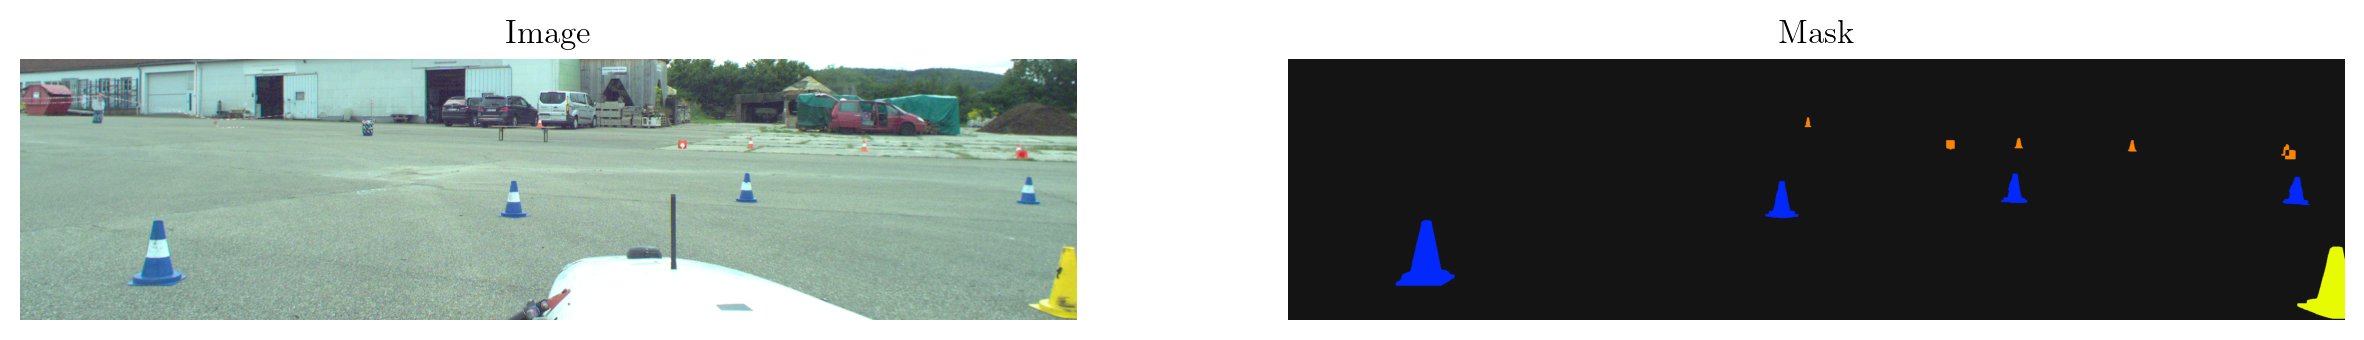

array([<Axes: title={'center': 'Image'}>,
       <Axes: title={'center': 'Mask'}>], dtype=object)

In [8]:
ds = ConeSegmentationDataset(mask_img_pairs, Normalize())
sample_img, sample_mask = ds[900]
visualize_from_torch(sample_img, sample_mask)